# trading_with_DL_rnn
Stock predictions via TF RNN-LSTM like ARIMA -- AR(3) 


## Assign input parameters

In [1]:
ticker='JPY=X'
ranged='5d'
interval='5m'
params={"nb_epoch": 10, "batch_size": 18, "look_back": 3, "train_ratio": 0.8, "dropout_keep_prob": 0.1 ,"const_YN":1}

In [2]:
pkgTF = !pip freeze | grep ^keras==
if not pkgTF:
  ! sudo pip install keras

You are using pip version 19.0.2, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## 1. Import packages and define utility functions

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import datetime
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os

def __del__(self):
	# cleanly ignore all exceptions
	try:
		self.close()
	except Exception: # pylint: disable=broad-except
		pass
	if self._session is not None:
		try:
			status = tf_session.TF_NewStatus()
			tf_session.TF_DeleteDeprecatedSession(self._session, status)
		finally:
			tf_session.TF_DeleteStatus(status)
		self._session = None

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=3,const_YN=0):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back):
                a = dataset[i:(i+look_back), 0]
                if const_YN==1:
                        a = np.append(a,1)
                dataX.append(a)
                dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

# split into train and test sets
def train_test_split(data,look_back=3,const_YN=1, train_ratio=0.85):
        X_raw, y_raw = create_dataset(data,look_back,const_YN=const_YN)
        train_size = int(len(dataset) * train_ratio)
        test_size = len(dataset) - train_size
        X_train, X_test = X_raw[0:train_size], X_raw[train_size:]
        y_train, y_test = y_raw[0:train_size], y_raw[train_size:]
        return (X_train, y_train), (X_test, y_test)


Using TensorFlow backend.


## 2. Load Data

In [4]:
os.environ['TZ']='America/New_York'

for ky,va in params.items():
        exec("{}=va".format(ky))

# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
# df = pd.read_csv('spy.csv')
# load data from yahoo
urx="https://query1.finance.yahoo.com/v8/finance/chart/{}?region=US&lang=en-US&includePrePost=false&interval={}&range={}"
url = urx.format(ticker,interval,ranged)
print(url)
jTmp = pd.read_json(url)['chart']['result'][0]
pbdatetime = [ datetime.datetime.fromtimestamp(int(x)) for x in jTmp['timestamp'] ]
df=pd.DataFrame(jTmp['indicators']['quote'][0])
df['price']=df['close']
df['datetime']=pbdatetime
df.dropna(inplace=True)
print(df[['datetime','price']].tail())

https://query1.finance.yahoo.com/v8/finance/chart/JPY=X?region=US&lang=en-US&includePrePost=false&interval=5m&range=5d
                datetime       price
1412 2019-06-28 20:40:00  107.870003
1413 2019-06-28 20:45:00  107.890999
1414 2019-06-28 20:50:00  107.924004
1415 2019-06-28 20:55:00  107.833000
1416 2019-06-28 21:00:00  107.820000


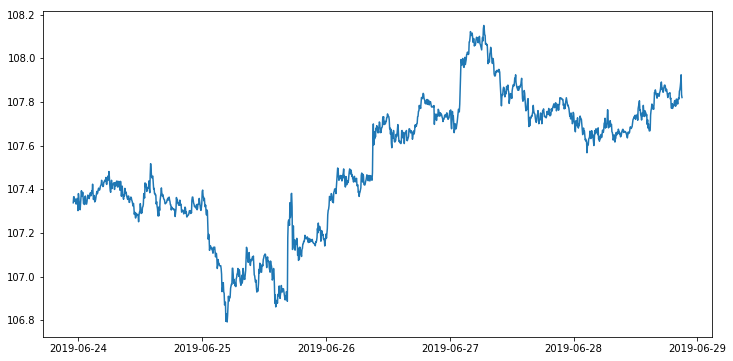

In [5]:
%matplotlib inline
fig, ax=plt.subplots(figsize=(12,6))
ax.plot(df['datetime'],df['price'])
plt.show()

## 3. Normalize the dataset

In [6]:
# normalize the dataset
dataset = df['price'].values
dataset = dataset.reshape(len(dataset),1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## 4. Split data into train and test sets

In [7]:
# split into train and test sets
(X_train,y_train),(X_test,y_test) = train_test_split(dataset,look_back,const_YN, train_ratio=train_ratio)
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [8]:
# Simplier model than in initial post
in_unit = X_train.shape[1]
out_unit = y_train.shape[-1]
hidden_unit = look_back+const_YN
print(X_train.shape,X_test.shape)

(1132, 4, 1) (280, 4, 1)


## 4. Fitting RNN with LSTM

In [9]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=4, return_sequences=True, input_shape=(4, 1)))
model.add(LSTM(hidden_unit,return_sequences=False))
model.add(Dropout(dropout_keep_prob))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1132/1132 [==============================] - 4s 3ms/step - loss: 0.1982
Epoch 2/10
1132/1132 [==============================] - 1s 806us/step - loss: 0.0725
Epoch 3/10
1132/1132 [==============================] - 1s 810us/step - loss: 0.0504
Epoch 4/10
1132/1132 [==============================] - 1s 807us/step - loss: 0.0479
Epoch 5/10
1132/1132 [==============================] - 1s 821us/step - loss: 0.0462
Epoch 6/10
1132/1132 [==============================] - 1s 767us/step - loss: 0.0416
Epoch 7/10
1132/1132 [==============================] - 1s 801us/step - loss: 0.0379
Epoch 8/10
1132/1132 [==============================] - 1s 786us/step - loss: 0.0310
Epoch 9/10
1132/1132 [==============================] - 1s 944us/step - loss: 0.0244
Ep

## 5. Making the predictions

In [10]:
# make predictions
pred_train = model.predict(X_train, batch_size=batch_size)
model.reset_states()
pred_test = model.predict(X_test, batch_size=batch_size)
# invert predictions
pred_train = scaler.inverse_transform(pred_train)
pred_y = scaler.inverse_transform([y_train])
pred_test = scaler.inverse_transform(pred_test)
act_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(pred_y[0], pred_train[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(act_test[0], pred_test[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.12 RMSE
Test Score: 0.05 RMSE


## 6. Plotting the baseline and predictions

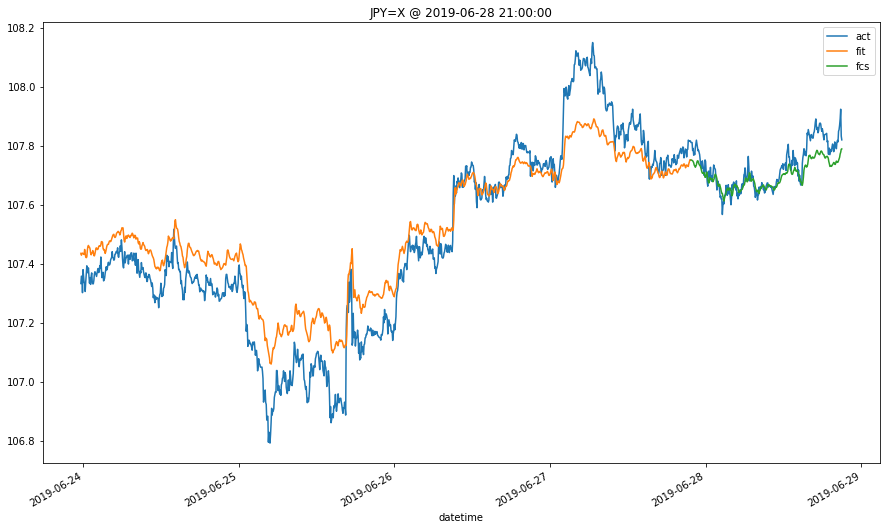

In [11]:
fig, ax2=plt.subplots(figsize=(15,9))
# plot baseline and predictions
pred_data=np.append(pred_train,pred_test)
ntrain=len(pred_train)
nobs=len(pred_data)
act_data=scaler.inverse_transform(dataset)[-nobs:]
actFitFcs=pd.DataFrame(np.column_stack([act_data,pred_data]),columns=['act','fit'])
actFitFcs['fcs']=actFitFcs['fit']
actFitFcs['fit'].iloc[ntrain:]=np.nan
actFitFcs['fcs'].iloc[:ntrain]=np.nan
#idxtm=map(lambda x:datetime.datetime.strptime(str(x),"%Y%m%d"),df['pbdate'].iloc[-nobs:])
idxtm=df['datetime'].iloc[-nobs:]
actFitFcs.set_index(pd.DatetimeIndex(idxtm),inplace=True)
title='{} @ {}'.format(ticker,idxtm.iloc[-1])
actFitFcs.iloc[-nobs+5:].plot(title=title,ax=ax2)
plt.show()


# Thank you for your attention